<a href="https://colab.research.google.com/github/danielwhitt/FATE/blob/main/float_deployment_experiments_aug82024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install copernicusmarine
# need copernicus marine username and password
import copernicusmarine

copernicusmarine.subset(
  dataset_id="cmems_mod_glo_phy-cur_anfc_0.083deg_PT6H-i",
  variables=["uo", "vo"],
  minimum_longitude=-174,
  maximum_longitude=-150,
  minimum_latitude=1,
  maximum_latitude=12,
  start_datetime="2024-08-08T18:00:00",
  end_datetime="2024-08-13T06:00:00",
  minimum_depth=13,
  maximum_depth=14,
)
#800 UTC-10 Aug 8 (SWOT target)


username: dwhitt1
password: ··········


INFO - 2024-08-05T17:57:24Z - Dataset version was not specified, the latest one was selected: "202406"
INFO:copernicus_marine_root_logger:Dataset version was not specified, the latest one was selected: "202406"
INFO - 2024-08-05T17:57:24Z - Dataset part was not specified, the first one was selected: "default"
INFO:copernicus_marine_root_logger:Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-05T17:57:27Z - Service was not specified, the default one was selected: "arco-time-series"
INFO:copernicus_marine_root_logger:Service was not specified, the default one was selected: "arco-time-series"
INFO - 2024-08-05T17:57:30Z - Downloading using service arco-time-series...
INFO:copernicus_marine_root_logger:Downloading using service arco-time-series...
INFO - 2024-08-05T17:57:35Z - <xarray.Dataset> Size: 6MB
Dimensions:    (depth: 1, latitude: 133, longitude: 289, time: 19)
Coordinates:
  * depth      (depth) float32 4B 13.47
  * latitude   (latitude) float32

 Y


INFO - 2024-08-05T17:57:38Z - Writing to local storage. Please wait...
INFO:copernicus_marine_root_logger:Writing to local storage. Please wait...


  0%|          | 0/840 [00:00<?, ?it/s]

INFO - 2024-08-05T17:58:11Z - Successfully downloaded to cmems_mod_glo_phy-cur_anfc_0.083deg_PT6H-i_uo-vo_174.00W-150.00W_1.00N-12.00N_13.47m_2024-08-08-2024-08-13.nc
INFO:copernicus_marine_root_logger:Successfully downloaded to cmems_mod_glo_phy-cur_anfc_0.083deg_PT6H-i_uo-vo_174.00W-150.00W_1.00N-12.00N_13.47m_2024-08-08-2024-08-13.nc


PosixPath('cmems_mod_glo_phy-cur_anfc_0.083deg_PT6H-i_uo-vo_174.00W-150.00W_1.00N-12.00N_13.47m_2024-08-08-2024-08-13.nc')

In [2]:
!pip install parcels
!pip install cftime
!pip install cgen
!pip install trajan
!pip install zarr
!pip install pymbolic

import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    download_example_dataset,
)

import parcels as ps

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.6/145.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.3 MB/s eta 0:00:00
  Created wheel for cgen: filename=cgen-2020.1-py3-none-any.whl size=15821 sha256=f6bc74d275279b445f1cf173480d1a85f61667eb0420e0b35c7aabcdbc3d8708
  Stored in directory: /root/.cache/pip/wheels/e6/64/97/7637a7ca9c143c1eaaeeb048c6e772677a68eb4d8695a9cc2a
  Created wheel for pymbolic: filename=pymbolic-2022.2-py3-none-any.whl size=127316 sha256=c4853c48513ca059714af7db90d86589260029cc9af31fe20835a1a3ee135116
  Stored in directory: /root/.cache/pip/wheels/c5/5e/88/b7f04b19af22919fcc93dbdaac8b755ba83bba22ad27e905ec
Successfully built cgen pymbolic
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/

In [4]:
dsF=xr.open_mfdataset("/content/cmems_mod_glo_phy-cur*.nc")

In [5]:
dsF

<xarray.Dataset> Size: 6MB
Dimensions:    (depth: 1, latitude: 133, longitude: 289, time: 19)
Coordinates:
  * depth      (depth) float32 4B 13.47
  * latitude   (latitude) float32 532B 1.0 1.083 1.167 1.25 ... 11.83 11.92 12.0
  * longitude  (longitude) float32 1kB -174.0 -173.9 -173.8 ... -150.1 -150.0
  * time       (time) datetime64[ns] 152B 2024-08-08T18:00:00 ... 2024-08-13T...
Data variables:
    uo         (time, depth, latitude, longitude) float32 3MB dask.array<chunksize=(19, 1, 133, 289), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 3MB dask.array<chunksize=(19, 1, 133, 289), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    institution:                   Mercator Ocean
    licence:                       http://marine.copernicus.eu/services-portf...
    ...                            ...
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLO12
    title:                         Instantaneous fields for product GLOBAL_AN...
    copernicusmarine_version:      1.3.2

In [6]:
variablesF = {
    "U": "uo",
    "V": "vo",
}
dimensionsF = {"time": "time", "lat": "latitude", "lon": "longitude"}


In [7]:
fieldsetF=FieldSet.from_xarray_dataset(dsF,variablesF,dimensionsF,allow_time_extrapolation=True)


In [8]:
psetF = ParticleSet.from_list(
    fieldset=fieldsetF,  # the fields on which the particles are advected
    pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle
    lon=[-162.222, -162.265,  -162.313, -161.950, -161.859, -161.905 ],  # a vector of release longitudes
    lat=[ 5.885,     5.806,     5.885,   5.885,   5.885,    5.961],  # a vector of release latitudes
)

In [9]:
psetF.lat

array([5.885, 5.806, 5.885, 5.885, 5.885, 5.961], dtype=float32)

In [10]:
output_fileF = psetF.ParticleFile(
    name="OSCARparticlesF.zarr", outputdt=timedelta(hours=4)
)
psetF.execute(
    AdvectionRK4,
    runtime=timedelta(days=4.5),
    dt=timedelta(minutes=20),
    output_file=output_fileF,
)

INFO: Output files are stored in OSCARparticlesF.zarr.


INFO:parcels.tools.loggers:Output files are stored in OSCARparticlesF.zarr.


100%|██████████| 388800.0/388800.0 [00:00<00:00, 571970.00it/s]


In [ ]:
psetF.lat

array([6.1721735, 6.2009687, 6.193309 , 6.3529077, 6.308652 , 6.051234 ,
       6.2414293, 6.1969857, 6.337642 , 6.1433673], dtype=float32)

In [11]:
from google.colab import drive

drive.mount('/content/drive')



Mounted at /content/drive


In [12]:
dsswot=xr.open_mfdataset("/content/drive/MyDrive/PalmyraSWOT/SWOT_L2_LR_SSH_Expert_018_375_20240723T070119_20240723T075205_PIC0_01.nc")

In [13]:
dsswot

<xarray.Dataset> Size: 400MB
Dimensions:                                (num_lines: 9866, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    longitude                              (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    latitude_nadir                         (num_lines) float64 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
    longitude_nadir                        (num_lines) float64 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/98)
    time                                   (num_lines) datetime64[ns] 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
    time_tai                               (num_lines) datetime64[ns] 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
    ssh_karin                              (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssh_karin_qual                         (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssh_karin_uncert                       (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssha_karin                             (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ...                                     ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    volumetric_correlation                 (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    volumetric_correlation_uncert          (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
Attributes: (12/62)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   CNES
    source:                                        Ka-band radar interferometer
    history:                                       2024-07-25T22:12:08Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_semi_major_axis:                     6378137.0
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       65.15048606315406
    ssha_variance:                                 0.40615288192637294
    references:                                    V1.2.1
    equator_longitude:                             -161.34

In [14]:
dsswot.longitude_nadir.values[5000]

198.83969499999998

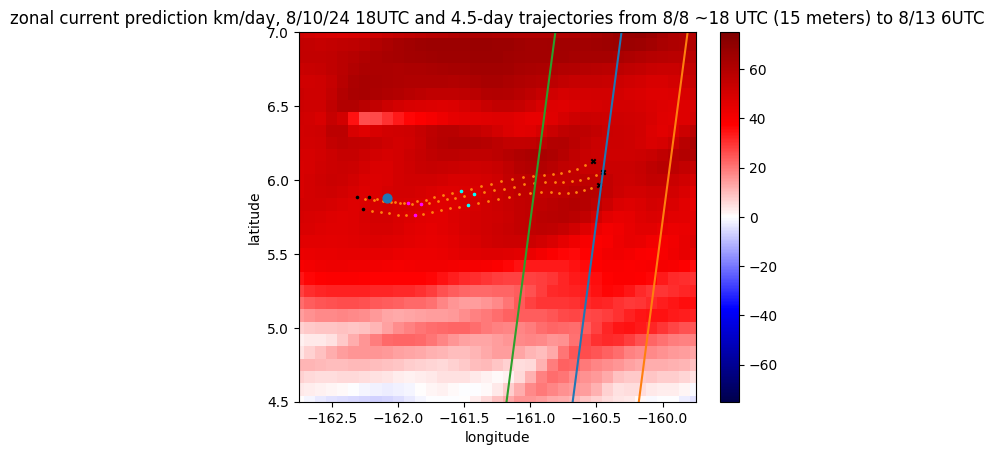

In [22]:
import seaborn as sns
from matplotlib.colors import ListedColormap
colors = sns.mpl_palette('Paired',n_colors=8)
cmap   = sns.mpl_palette('Paired',n_colors=8,as_cmap=True)
plt.pcolormesh(fieldsetF.V.grid.lon, fieldsetF.V.grid.lat, fieldsetF.U.data[8, :, :]*86.4)
plt.set_cmap('seismic')
plt.colorbar()
plt.xlim(-162.75,-159.75)
plt.ylim(4.5,7)
plt.clim(-75,75)
plt.title('zonal current prediction km/day, 8/10/24 18UTC and 4.5-day trajectories from 8/8 ~18 UTC (15 meters) to 8/13 6UTC')

ds = xr.open_zarr("OSCARparticlesF.zarr")

plt.plot(dsswot.longitude_nadir-360,dsswot.latitude_nadir)
plt.plot(dsswot.longitude_nadir-359.5,dsswot.latitude_nadir)
plt.plot(dsswot.longitude_nadir-360.5,dsswot.latitude_nadir)


plt.scatter(ds.lon[0:3,:],ds.lat[0:3,:],c='#ff7f0e',s=4,marker='.')
plt.scatter(ds.lon[0:3,0],ds.lat[0:3,0],s=10,marker='.',c='k')
plt.scatter(ds.lon[0:3,6],ds.lat[0:3,6],s=10,marker='.',c='magenta')
plt.scatter(ds.lon[0:3,12],ds.lat[0:3,12],s=10,marker='.',c='cyan')
plt.scatter(ds.lon[0:3,26],ds.lat[0:3,26],s=10,marker='x',c='k')

#plt.scatter(j31lon,j31lat,s=4,marker='o',c='grey')


plt.scatter([-162.08],[5.88],s=40,marker='o')
#plt.scatter([-162.05],[5.88],s=40,marker='o')
#plt.scatter([-162.11],[5.88],s=40,marker='o')


plt.ylabel("latitude")
plt.xlabel("longitude")
#plt.scatter(ds1.lon[:,:],ds1.lat[:,:],s=4,c='#ff7f0e',marker='.')

plt.show()
